In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Model 1: Basic GP

In [2]:
modeWeightsOrig = pd.read_csv(r'Mode_Weight_Full_Cohort.csv',index_col='Mesh_ID')
print(modeWeightsOrig)

               Mode1      Mode2      Mode3      Mode4      Mode5      Mode6  \
Mesh_ID                                                                       
1         -26.526282 -21.987510  45.298672   6.964297   1.264487 -14.710058   
2         -16.902798  23.644504  19.452896 -24.329813 -25.447350  20.415574   
3          14.528402  16.328970  -5.269040  31.653975   7.173021  17.494031   
4         -15.076964  28.889168   8.644859   4.758042   1.301095   5.983310   
5          -3.839848 -47.723637   7.042452  -4.914959  -4.014415  20.366371   
6          18.372208 -13.173184 -10.191443 -24.148353   5.156296  -5.613573   
7         -34.355273 -16.804885  -6.838693 -12.785964   5.546781 -11.206395   
8         -25.433101   7.377060  16.518874  10.553323  20.454561  -3.834116   
11         80.119501   6.505305   4.707190  18.693887 -17.988034  -9.927770   
12         51.114176 -25.099497  -6.603593  -1.858095   2.108524   6.369323   
13          2.227391  21.550335  14.556385 -15.90453

In [3]:
modelOutputOrig = pd.read_csv(r'simulation_output_Full_Cohort.csv',index_col=0)
print(modelOutputOrig)

            EDV_LV  Myo_vol_LV  ESV_LV   SV_LV    V1_LV     EF1_LV  \
Mesh_ID                                                              
1          119.650  163.305835  55.614  64.036   90.248  24.573339   
2          128.603  202.159662  51.027  77.576   98.402  23.483900   
3          152.279  154.973015  65.778  86.501  110.147  27.667636   
4          145.034  199.463111  57.180  87.854  105.630  27.168802   
5          118.599   91.976665  55.855  62.744   94.714  20.139293   
6           85.968  109.660211  40.184  45.784   68.640  20.156337   
7          113.130   94.998853  49.677  63.453   84.963  24.897905   
8          142.547  135.194656  64.998  77.549  107.610  24.509109   
11         140.874  140.723552  65.420  75.454  107.909  23.400344   
12         101.382  101.575101  45.137  56.245   77.413  23.642264   
13         139.551  152.838953  59.194  80.357  103.644  25.730378   
14         176.987  167.319878  79.883  97.104  129.387  26.894631   
15         103.318  

In [4]:
def normalise(data):
    dataMean = np.mean(data,axis=0)
    dataStd = np.std(data,axis=0)
    dataNorm = (data-dataMean)/(dataStd)
    return dataNorm,dataMean,dataStd

In [5]:
inputNorm,inputMean,inputStd = normalise(modeWeightsOrig)

In [6]:
outputNorm,outMean,outStd=normalise(modelOutputOrig)

In [7]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=18))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
class ZeroMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ZeroMeanGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=18))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [9]:
def GPEnsemble(modelInput,modelOutput,zeroMean=False):
    models = []
    likelihoods = []
    MSE = []
    nMod = modelOutput.shape[1]
    for i in range(nMod):
        print(i)
        likelihoods.append(gpytorch.likelihoods.GaussianLikelihood())
        if zeroMean==False:
            models.append(ExactGPModel(torch.tensor(modelInput.values), torch.tensor(modelOutput.iloc[:,i].values).squeeze(), likelihoods[i]))
        else:
            models.append(ZeroMeanGPModel(torch.tensor(modelInput.values), torch.tensor(modelOutput.iloc[:,i].values).squeeze(), likelihoods[i]))
        smoke_test = ('CI' in os.environ)
        training_iter = 2 if smoke_test else 100


        # Find optimal model hyperparameters
        models[i].train()
        likelihoods[i].train()
        X=torch.tensor(modelInput.values)
        Y=torch.tensor(modelOutput.iloc[:,i].values).squeeze()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(models[i] .parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihoods[i], models[i] )


        for j in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = models[i](X)
            # Calc loss and backprop gradients
            loss = -mll(output, Y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #    j + 1, training_iter, loss.item(),
            #    models[i].covar_module.base_kernel.lengthscale.item(),
            #    models[i].likelihood.noise.item()
            #))
            optimizer.step()
    return models, likelihoods

In [10]:
def LRGPEnsemble(modelInput,modelOutput):
    
    nMod = modelOutput.shape[1]
    #outMean = np.mean(modelOutput,axis=0)
    #outStd = np.std(modelOutput,axis=0)
    #modelOutputNew = (modelOutput-outMean)/outStd.T
    #inMean = np.mean(modelInput,axis=0)
    #inStd = np.std(modelInput,axis=0)
    #modelInputNew = (modelInput-inMean)/inStd.T
    
    regression_model = LinearRegression()
    # Fit the data(train the model)
    regression_model.fit(modelInput, modelOutput)
    
    y_predicted = regression_model.predict(modelInput)
    
    modelOutputAdjusted = modelOutput - y_predicted
    
    modelsZM, likelihoodsZM = GPEnsemble(modelInput,modelOutputAdjusted,zeroMean=True)
    
    return regression_model, modelsZM, likelihoodsZM

In [11]:
def GPEnsemblePredict(models,likelihoods,inputVals,outMean,outStd):
    #modelOutput = (modelOutputOrig-outMean)/outStd.T
    nMod = len(models)
    prediction=[]
    inputVals = inputVals.float()
    for i in range(nMod):
        models[i].eval()
        likelihoods[i].eval()
        out = outStd[i]*(likelihoods[i](models[i](inputVals)).mean)+outMean[i]
        prediction.append(out)
    return prediction

In [12]:
def LRGPEnsemblePredict(linearModel,models,likelihoods,inputVals,outMean,outStd):
    nMod = len(models)
    
    y_predictedSens = linearModel.predict(inputVals)
    inputVals = inputVals.float()
    prediction=[]
    for i in range(nMod):
        models[i].eval()
        likelihoods[i].eval()
        out = outStd[i]*(torch.tensor([y_predictedSens[:,i]])+likelihoods[i](models[i](inputVals)).mean)+outMean[i]
        prediction.append(out)
    return prediction


In [13]:
models, likelihoods = GPEnsemble(inputNorm,outputNorm)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [14]:
boundsMaxMin = []
for i in range(9):
    boundsMaxMin.append([np.min(inputNorm.iloc[:,i]),np.max(inputNorm.iloc[:,i])])
    print(boundsMaxMin[i])

[-3.2480941544487276, 3.318592842556511]
[-2.7072817659457096, 3.958302105216277]
[-3.6931734722976803, 2.868795326295566]
[-3.275565095341213, 3.230839217901113]
[-3.2593923860002088, 3.26978710109374]
[-2.582100067980238, 3.599146858924995]
[-3.239605609611834, 3.250156275350689]
[-3.240384149741675, 3.6497474638640166]
[-3.8669104995119534, 3.635490844267935]


In [15]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': 9,
    'names': ['Mode 1', 'Mode 2', 'Mode 3', 'Mode 4','Mode 5','Mode 6', 'Mode 7', 'Mode 8', 'Mode 9'],
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 2048)

data1 = torch.tensor(np.hstack((param_values,np.zeros((param_values.shape[0],9)))))
Ymean=GPEnsemblePredict(models,likelihoods,data1,outMean,outStd)
# Run model (example)
#outMean = np.mean(modelOutputOrig,axis=0)
#outStd = np.std(modelOutputOrig,axis=0)
#nMod = modelOutputOrig.shape[1]
#Ymean=[]
#for j in range(nMod):
#    models[j].eval()
#    #Ymean.append(np.zeros([param_values.shape[0]]))
#    Ymean.append(outStd[j]*models[j](torch.tensor([np.hstack((param_values,np.zeros((param_values.shape[0],9))))])).mean+outMean[j])

    

C:\Users\pmzcwl\AppData\Local\Temp\ipykernel_12768\3389100392.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2048)


In [16]:
Si = []
nMod = modelOutputOrig.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[i].detach().numpy().squeeze(), print_to_console=True))

              ST   ST_conf
Mode 1  0.022630  0.001520
Mode 2  0.363223  0.022583
Mode 3  0.197659  0.012511
Mode 4  0.267163  0.018342
Mode 5  0.010405  0.000705
Mode 6  0.027350  0.002379
Mode 7  0.006174  0.000473
Mode 8  0.001977  0.000148
Mode 9  0.132585  0.009837
              S1   S1_conf
Mode 1  0.021254  0.008549
Mode 2  0.346193  0.035708
Mode 3  0.192759  0.022970
Mode 4  0.260982  0.028495
Mode 5  0.010638  0.005823
Mode 6  0.003593  0.009486
Mode 7  0.005892  0.004934
Mode 8  0.000829  0.002660
Mode 9  0.126191  0.018587
                        S2   S2_conf
(Mode 1, Mode 2)  0.000659  0.016080
(Mode 1, Mode 3)  0.000695  0.013710
(Mode 1, Mode 4)  0.001065  0.014600
(Mode 1, Mode 5)  0.000857  0.014405
(Mode 1, Mode 6)  0.001432  0.014454
(Mode 1, Mode 7)  0.000794  0.014284
(Mode 1, Mode 8)  0.000892  0.014092
(Mode 1, Mode 9)  0.000787  0.014248
(Mode 2, Mode 3)  0.003450  0.050699
(Mode 2, Mode 4)  0.004341  0.055517
(Mode 2, Mode 5)  0.001697  0.047643
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.376992  0.026661
Mode 2  0.363670  0.024260
Mode 3  0.002954  0.000246
Mode 4  0.074564  0.005304
Mode 5  0.009527  0.000717
Mode 6  0.008378  0.000606
Mode 7  0.007203  0.000651
Mode 8  0.074349  0.006198
Mode 9  0.167818  0.011837
              S1   S1_conf
Mode 1  0.329317  0.041133
Mode 2  0.299949  0.033008
Mode 3  0.001273  0.003617
Mode 4  0.065438  0.016172
Mode 5  0.009127  0.006125
Mode 6  0.005588  0.006505
Mode 7  0.003772  0.004624
Mode 8  0.069204  0.015846
Mode 9  0.142579  0.021002
                        S2   S2_conf
(Mode 1, Mode 2)  0.031590  0.055636
(Mode 1, Mode 3) -0.000629  0.050712
(Mode 1, Mode 4) -0.001464  0.055585
(Mode 1, Mode 5) -0.001220  0.051503
(Mode 1, Mode 6) -0.000727  0.052541
(Mode 1, Mode 7)  0.000598  0.052366
(Mode 1, Mode 8) -0.000193  0.054984
(Mode 1, Mode 9)  0.005664  0.054338
(Mode 2, Mode 3) -0.008428  0.041171
(Mode 2, Mode 4) -0.002814  0.043397
(Mode 2, Mode 5) -0.008789  0.041425
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.001072  0.000607
Mode 2  0.054452  0.033431
Mode 3  0.433332  0.127509
Mode 4  0.042857  0.027477
Mode 5  0.177172  0.048540
Mode 6  0.000643  0.000199
Mode 7  0.811613  0.112845
Mode 8  0.284175  0.053330
Mode 9  0.074748  0.038542
              S1   S1_conf
Mode 1  0.000429  0.001233
Mode 2  0.009195  0.009900
Mode 3  0.069421  0.054462
Mode 4  0.006832  0.012959
Mode 5  0.022568  0.022361
Mode 6 -0.000644  0.001077
Mode 7  0.161055  0.111281
Mode 8  0.007204  0.030843
Mode 9 -0.002717  0.013942
                        S2   S2_conf
(Mode 1, Mode 2)  0.000041  0.002954
(Mode 1, Mode 3)  0.000003  0.003362
(Mode 1, Mode 4)  0.001035  0.004751
(Mode 1, Mode 5) -0.000390  0.003172
(Mode 1, Mode 6) -0.000364  0.002801
(Mode 1, Mode 7) -0.003868  0.004420
(Mode 1, Mode 8) -0.000266  0.002747
(Mode 1, Mode 9)  0.000230  0.003216
(Mode 2, Mode 3) -0.015114  0.016494
(Mode 2, Mode 4) -0.007521  0.011486
(Mode 2, Mode 5) -0.009513  0.011543
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.035769  0.002556
Mode 2  0.694818  0.038909
Mode 3  0.157343  0.011672
Mode 4  0.110339  0.007145
Mode 5  0.003236  0.000205
Mode 6  0.012882  0.001045
Mode 7  0.003863  0.000268
Mode 8  0.000287  0.000026
Mode 9  0.003193  0.000318
              S1   S1_conf
Mode 1  0.033147  0.010523
Mode 2  0.678035  0.050910
Mode 3  0.149070  0.022808
Mode 4  0.106203  0.017642
Mode 5  0.004043  0.003527
Mode 6  0.000372  0.006363
Mode 7  0.003720  0.003778
Mode 8  0.000288  0.001148
Mode 9  0.002313  0.003840
                        S2   S2_conf
(Mode 1, Mode 2)  0.001665  0.018658
(Mode 1, Mode 3)  0.000266  0.015252
(Mode 1, Mode 4)  0.000255  0.015018
(Mode 1, Mode 5)  0.000024  0.014742
(Mode 1, Mode 6)  0.000738  0.014587
(Mode 1, Mode 7)  0.000018  0.014660
(Mode 1, Mode 8)  0.000009  0.014575
(Mode 1, Mode 9)  0.000052  0.014706
(Mode 2, Mode 3)  0.004569  0.062981
(Mode 2, Mode 4)  0.003017  0.059023
(Mode 2, Mode 5) -0.001065  0.054074
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.047946  0.003049
Mode 2  0.655877  0.032716
Mode 3  0.138793  0.008561
Mode 4  0.156990  0.011907
Mode 5  0.000388  0.000033
Mode 6  0.000632  0.000050
Mode 7  0.000799  0.000056
Mode 8  0.007450  0.000457
Mode 9  0.001498  0.000111
              S1   S1_conf
Mode 1  0.045283  0.013426
Mode 2  0.643696  0.039086
Mode 3  0.135303  0.022202
Mode 4  0.151005  0.021134
Mode 5  0.001195  0.001135
Mode 6  0.000076  0.001527
Mode 7  0.000586  0.002092
Mode 8  0.006836  0.005734
Mode 9  0.000984  0.002364
                        S2   S2_conf
(Mode 1, Mode 2)  0.002054  0.023770
(Mode 1, Mode 3)  0.000717  0.017753
(Mode 1, Mode 4)  0.001141  0.018306
(Mode 1, Mode 5)  0.000605  0.016871
(Mode 1, Mode 6)  0.000654  0.016920
(Mode 1, Mode 7)  0.000687  0.016954
(Mode 1, Mode 8)  0.000739  0.017318
(Mode 1, Mode 9)  0.000729  0.016858
(Mode 2, Mode 3)  0.002651  0.055740
(Mode 2, Mode 4)  0.003666  0.051033
(Mode 2, Mode 5) -0.000913  0.049559
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.025255  0.018555
Mode 2  0.005415  0.004226
Mode 3  0.045035  0.032382
Mode 4  0.000715  0.000587
Mode 5  0.429556  0.324274
Mode 6  0.000350  0.000327
Mode 7  0.863754  0.469168
Mode 8  0.870138  0.354857
Mode 9  0.002480  0.002349
              S1   S1_conf
Mode 1  0.003189  0.005427
Mode 2  0.002123  0.003615
Mode 3 -0.010217  0.013575
Mode 4 -0.000203  0.001111
Mode 5  0.025651  0.048436
Mode 6  0.000299  0.001179
Mode 7  0.055947  0.066049
Mode 8  0.025653  0.071316
Mode 9  0.000153  0.000642
                        S2   S2_conf
(Mode 1, Mode 2) -0.003920  0.006523
(Mode 1, Mode 3) -0.005161  0.008009
(Mode 1, Mode 4) -0.004065  0.006695
(Mode 1, Mode 5) -0.001082  0.004637
(Mode 1, Mode 6) -0.004032  0.006687
(Mode 1, Mode 7) -0.005417  0.007137
(Mode 1, Mode 8) -0.003153  0.014080
(Mode 1, Mode 9) -0.004039  0.006649
(Mode 2, Mode 3) -0.004639  0.009440
(Mode 2, Mode 4) -0.005536  0.011103
(Mode 2, Mode 5) -0.007357  0.014703
(Mode 2, Mode 6)

# Model 2: Linear regression + Zero Mean GP

In [17]:
regression_model, modelsZM, likelihoodsZM=LRGPEnsemble(inputNorm,outputNorm)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [18]:


# generate random data-set

# sckit-learn implementation

# Model initialization
#regression_model = LinearRegression()
# Fit the data(train the model)
#regression_model.fit(modeWeights, modelOutput)
# Predict
#y_predicted = regression_model.predict(modeWeights)

# model evaluation
#rmse = mean_squared_error(modelOutput, y_predicted)
#r2 = r2_score(modelOutput, y_predicted)

# printing values
#print('Slope:' ,regression_model.coef_)
#print('Intercept:', regression_model.intercept_)
#print('Root mean squared error: ', rmse)
#print('R2 score: ', r2)


In [19]:
#modelOutputAdjusted = modelOutput - y_predicted

In [20]:
#modelsZM, likelihoodsZM = GPEnsemble(modeWeights,modelOutputAdjusted,zeroMean=True)

In [21]:
YmeanSens = LRGPEnsemblePredict(regression_model,modelsZM,likelihoodsZM,data1,outMean,outStd)

C:\Users\pmzcwl\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\pmzcwl\AppData\Local\Temp\ipykernel_12768\4188212139.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  out = outStd[i]*(torch.tensor([y_predictedSens[:,i]])+likelihoods[i](models[i](inputVals)).mean)+outMean[i]


In [22]:
SiZM = []
nMod = modelOutputOrig.shape[1]
for i in range(nMod):
    SiZM.append(sobol.analyze(problem, YmeanSens[i].detach().numpy().squeeze(), print_to_console=True))

              ST   ST_conf
Mode 1  0.024586  0.001774
Mode 2  0.313393  0.018555
Mode 3  0.185499  0.011014
Mode 4  0.294641  0.016464
Mode 5  0.012201  0.000751
Mode 6  0.000210  0.000013
Mode 7  0.003691  0.000210
Mode 8  0.002457  0.000165
Mode 9  0.163503  0.009508
              S1   S1_conf
Mode 1  0.024598  0.007998
Mode 2  0.313225  0.032065
Mode 3  0.185448  0.028504
Mode 4  0.294633  0.026389
Mode 5  0.012201  0.005912
Mode 6  0.000211  0.000862
Mode 7  0.003678  0.004148
Mode 8  0.002446  0.002711
Mode 9  0.163544  0.022778
                        S2   S2_conf
(Mode 1, Mode 2)  0.000051  0.014195
(Mode 1, Mode 3)  0.000084  0.013396
(Mode 1, Mode 4)  0.000073  0.013623
(Mode 1, Mode 5)  0.000077  0.012145
(Mode 1, Mode 6)  0.000077  0.012267
(Mode 1, Mode 7)  0.000077  0.012295
(Mode 1, Mode 8)  0.000070  0.012272
(Mode 1, Mode 9) -0.000015  0.013117
(Mode 2, Mode 3)  0.000043  0.047654
(Mode 2, Mode 4)  0.000070  0.051982
(Mode 2, Mode 5) -0.000002  0.043652
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.280603  0.017696
Mode 2  0.388674  0.024547
Mode 3  0.009914  0.000604
Mode 4  0.137752  0.008467
Mode 5  0.032589  0.002099
Mode 6  0.004028  0.000259
Mode 7  0.004213  0.000255
Mode 8  0.074681  0.004459
Mode 9  0.068470  0.004212
              S1   S1_conf
Mode 1  0.279894  0.034558
Mode 2  0.389053  0.036186
Mode 3  0.009888  0.005598
Mode 4  0.137933  0.021600
Mode 5  0.032736  0.010870
Mode 6  0.004060  0.004098
Mode 7  0.004286  0.003231
Mode 8  0.074568  0.017157
Mode 9  0.067613  0.015403
                        S2   S2_conf
(Mode 1, Mode 2)  0.000619  0.053003
(Mode 1, Mode 3)  0.001087  0.045422
(Mode 1, Mode 4)  0.000832  0.049504
(Mode 1, Mode 5)  0.000915  0.043557
(Mode 1, Mode 6)  0.001019  0.045102
(Mode 1, Mode 7)  0.001130  0.044881
(Mode 1, Mode 8)  0.000759  0.046961
(Mode 1, Mode 9)  0.001192  0.049382
(Mode 2, Mode 3) -0.000361  0.047471
(Mode 2, Mode 4)  0.000100  0.050811
(Mode 2, Mode 5) -0.000415  0.049713
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.000682  0.000042
Mode 2  0.101517  0.006171
Mode 3  0.319277  0.019560
Mode 4  0.083836  0.005210
Mode 5  0.094330  0.005868
Mode 6  0.002929  0.000182
Mode 7  0.011187  0.000641
Mode 8  0.000081  0.000006
Mode 9  0.386434  0.021450
              S1   S1_conf
Mode 1  0.000689  0.001373
Mode 2  0.101506  0.019124
Mode 3  0.319282  0.030414
Mode 4  0.083843  0.016768
Mode 5  0.094376  0.018315
Mode 6  0.002912  0.003430
Mode 7  0.011224  0.005763
Mode 8  0.000119  0.000514
Mode 9  0.386378  0.033241
                            S2   S2_conf
(Mode 1, Mode 2) -2.905112e-05  0.002169
(Mode 1, Mode 3) -2.267557e-05  0.002448
(Mode 1, Mode 4) -3.126121e-05  0.002114
(Mode 1, Mode 5) -3.056820e-05  0.002208
(Mode 1, Mode 6) -3.025644e-05  0.002115
(Mode 1, Mode 7) -3.281241e-05  0.002122
(Mode 1, Mode 8) -3.016984e-05  0.002105
(Mode 1, Mode 9) -8.325414e-06  0.002465
(Mode 2, Mode 3)  1.317680e-05  0.033283
(Mode 2, Mode 4)  5.896098e-05  0.029158
(Mode 2, 

              ST   ST_conf
Mode 1  0.049899  0.002899
Mode 2  0.500333  0.030458
Mode 3  0.256018  0.015616
Mode 4  0.124819  0.007004
Mode 5  0.001798  0.000100
Mode 6  0.008504  0.000559
Mode 7  0.007298  0.000403
Mode 8  0.000596  0.000036
Mode 9  0.051778  0.003180
              S1   S1_conf
Mode 1  0.049761  0.014953
Mode 2  0.499811  0.035966
Mode 3  0.255577  0.030298
Mode 4  0.124706  0.020496
Mode 5  0.001928  0.002464
Mode 6  0.007965  0.005284
Mode 7  0.007323  0.004994
Mode 8  0.000426  0.001681
Mode 9  0.050841  0.013060
                        S2   S2_conf
(Mode 1, Mode 2) -0.000201  0.024113
(Mode 1, Mode 3) -0.000079  0.020383
(Mode 1, Mode 4) -0.000115  0.018768
(Mode 1, Mode 5) -0.000115  0.016818
(Mode 1, Mode 6) -0.000048  0.016769
(Mode 1, Mode 7) -0.000130  0.017091
(Mode 1, Mode 8) -0.000060  0.016884
(Mode 1, Mode 9)  0.000185  0.017911
(Mode 2, Mode 3)  0.000034  0.053663
(Mode 2, Mode 4) -0.000191  0.053301
(Mode 2, Mode 5) -0.000090  0.049943
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.063007  0.003614
Mode 2  0.509629  0.030475
Mode 3  0.219030  0.013557
Mode 4  0.145979  0.009444
Mode 5  0.000038  0.000003
Mode 6  0.007897  0.000472
Mode 7  0.002238  0.000129
Mode 8  0.000769  0.000057
Mode 9  0.052873  0.003651
              S1   S1_conf
Mode 1  0.063000  0.015897
Mode 2  0.508761  0.040723
Mode 3  0.218576  0.027034
Mode 4  0.145806  0.020688
Mode 5  0.000081  0.000388
Mode 6  0.007463  0.005395
Mode 7  0.002233  0.002855
Mode 8  0.000543  0.001763
Mode 9  0.051729  0.012586
                        S2   S2_conf
(Mode 1, Mode 2) -0.000293  0.026509
(Mode 1, Mode 3) -0.000174  0.025100
(Mode 1, Mode 4) -0.000069  0.026291
(Mode 1, Mode 5) -0.000203  0.023268
(Mode 1, Mode 6) -0.000183  0.023551
(Mode 1, Mode 7) -0.000202  0.023131
(Mode 1, Mode 8) -0.000114  0.023220
(Mode 1, Mode 9)  0.000097  0.023972
(Mode 2, Mode 3)  0.000056  0.066930
(Mode 2, Mode 4) -0.000328  0.060642
(Mode 2, Mode 5) -0.000038  0.057967
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.052629  0.003160
Mode 2  0.158237  0.010294
Mode 3  0.015873  0.000929
Mode 4  0.001932  0.000125
Mode 5  0.208356  0.013218
Mode 6  0.013317  0.000930
Mode 7  0.005018  0.000420
Mode 8  0.016313  0.001178
Mode 9  0.529554  0.031529
              S1   S1_conf
Mode 1  0.052444  0.013258
Mode 2  0.158251  0.022047
Mode 3  0.016182  0.008204
Mode 4  0.001972  0.002536
Mode 5  0.207903  0.027166
Mode 6  0.013116  0.007031
Mode 7  0.005189  0.004404
Mode 8  0.017131  0.007436
Mode 9  0.529519  0.033400
                        S2   S2_conf
(Mode 1, Mode 2)  0.000398  0.020564
(Mode 1, Mode 3)  0.000273  0.019003
(Mode 1, Mode 4)  0.000396  0.018336
(Mode 1, Mode 5)  0.000506  0.019730
(Mode 1, Mode 6)  0.000391  0.019142
(Mode 1, Mode 7)  0.000500  0.018402
(Mode 1, Mode 8)  0.000269  0.018113
(Mode 1, Mode 9)  0.000123  0.024104
(Mode 2, Mode 3) -0.000166  0.034090
(Mode 2, Mode 4) -0.000177  0.033295
(Mode 2, Mode 5)  0.000018  0.034849
(Mode 2, Mode 6)

In [23]:
SiZM_first=np.zeros((9,nMod))
SiZM_total=np.zeros((9,nMod))
Si_first=np.zeros((9,nMod))
Si_total=np.zeros((9,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = SiZM[i].to_df()
    SiZM_first[:,i] =  first_Si.iloc[:,0]
    SiZM_total[:,i] =  total_Si.iloc[:,0]
    
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

## Linear Regression + GP

In [24]:
modelOutputOrig.index[1]

'2'

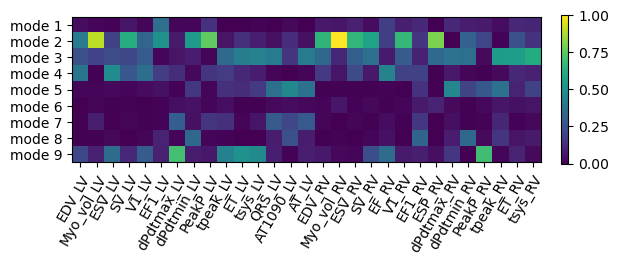

In [25]:
modes = ["mode 1", "mode 2", "mode 3", "mode 4",
              "mode 5", "mode 6", "mode 7", "mode 8", "mode 9"]
outputs = list(modelOutputOrig.columns)

fig, ax = plt.subplots()
im = ax.imshow(SiZM_first/np.max(SiZM_first))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [26]:
SiZM_first[:,2]

array([6.33323582e-03, 1.45306926e-01, 1.77643508e-01, 3.69816554e-01,
       1.53499653e-02, 1.09990282e-03, 3.01847864e-04, 1.39674732e-02,
       2.69239929e-01])

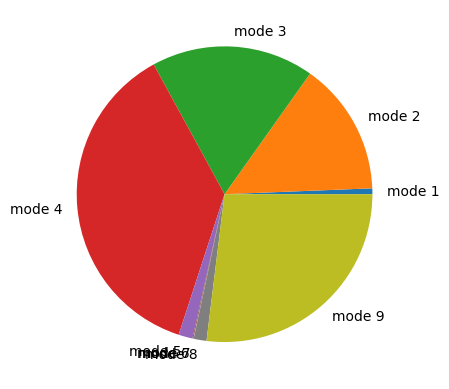

In [27]:
fig, ax = plt.subplots()
ax.pie(SiZM_first[:,2]/np.max(SiZM_first[:,2]), labels=modes);


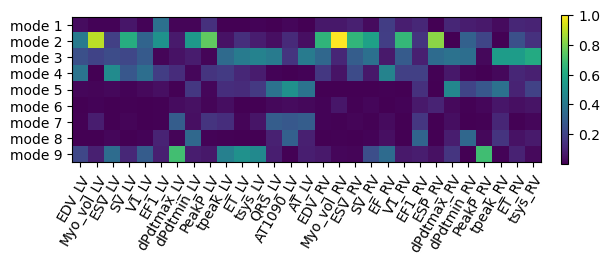

In [28]:
fig, ax = plt.subplots()
im = ax.imshow(SiZM_total/np.max(SiZM_total))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");
plt.colorbar(im,fraction=0.015, pad=0.04)

## Basic GP

In [29]:
np.max(SiZM_total)

0.7640921916545335

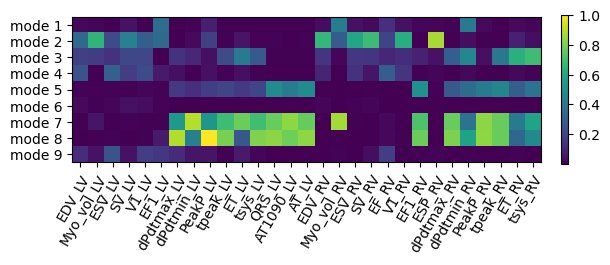

In [30]:
fig, ax = plt.subplots()
im = ax.imshow(Si_total/np.max(Si_total))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [31]:
Si_first[:,2]

array([0.0029636 , 0.22422475, 0.14634941, 0.31411613, 0.01223837,
       0.00299052, 0.00220807, 0.0077768 , 0.25818035])

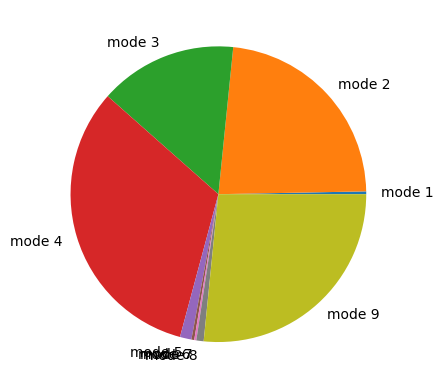

In [32]:
fig, ax = plt.subplots()
ax.pie(Si_first[:,2]/np.max(Si_first[:,2]), labels=modes);


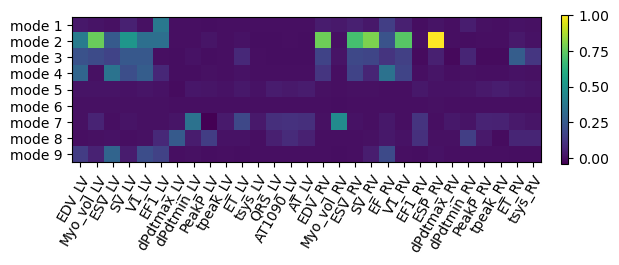

In [33]:
fig, ax = plt.subplots()
im = ax.imshow(Si_first/np.max(Si_first))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

# Leave one out MSE

In [34]:
import random

In [35]:
def standardise(data,mean,std):
    dataStandard = (data-mean)/std.T
    return dataStandard

In [36]:
def EnsembleMSE(models,likelihoods,modelInput,modelOutput):
    MSE = np.zeros(modelOutput.shape[1])
    nMod=len(models)
    for i in range(nMod):
        models[i].eval()
        likelihoods[i].eval()
        MSE[i] = (((outputTrainStd[i]*likelihoods[i](models[i](torch.tensor(modelInput.values).float())).mean-outputTrainStd[i]*torch.tensor(modelOutput.iloc[:,i].values))**2).mean());
    return MSE

In [37]:
def LREnsembleMSE(GPmodels,likelihoods,LRModel,modelInput,modelOutput):
    MSE = np.zeros(modelOutput.shape[1])
    nMod = len(models)
    y_predicted = regression_model.predict(modelInput)
    for i in range(nMod):
        GPmodels[i].eval()
        likelihoods[i].eval()
        MSE[i] = (((outputTrainStd[i]*(torch.tensor(y_predicted[:,i])+likelihoods[i](GPmodels[i](torch.tensor(modelInput.values).float())).mean)-outputTrainStd[i]*torch.tensor(modelOutput.iloc[:,i].values))**2).mean());
    return MSE

In [38]:
random.sample(range(0,50),10)

[14, 18, 38, 32, 28, 30, 24, 34, 6, 46]

In [41]:
GP_MSE = np.zeros(outputNorm.shape[1])
LRGP_MSE = np.zeros(outputNorm.shape[1])

iters = inputNorm.shape[0]
nMod = outputNorm.shape[1]



for i in range(iters):

    models2=[]
    likelihoods2=[]
    
    modelsZM2=[]
    likelihoodsZM2=[]


    testIndices = [i]
    inputTest = modeWeightsOrig.iloc[testIndices,:]
    inputTrain = modeWeightsOrig[~modeWeightsOrig.index.isin([modeWeightsOrig.index[i]])]
    outputTest = modelOutputOrig.iloc[testIndices,:]
    outputTrain = modelOutputOrig.iloc[~modelOutputOrig.index.isin([modelOutputOrig.index[i]])]
    
    inputTrainNorm,inputTrainMean,inputTrainStd = normalise(inputTrain)
    inputTestNorm=(inputTest-inputTrainMean)/inputTrainStd
    
    outputTrainNorm,outputTrainMean,outputTrainStd = normalise(outputTrain)
    outputTestNorm=(outputTest-outputTrainMean)/outputTrainStd
    y_predicted = regression_model.predict(inputTrainNorm)

    for j in range(nMod):

        likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
        model2 = ExactGPModel(torch.tensor(inputTrainNorm.values), torch.tensor(outputTrainNorm.iloc[:,j].values).squeeze(), likelihood2)


        model2.likelihood.noise_covar.noise= models[j].likelihood.noise_covar.noise,
        model2.covar_module.base_kernel.lengthscale= models[j].covar_module.base_kernel.lengthscale.tolist(),
        model2.covar_module.outputscale=models[j].covar_module.outputscale,
        model2.mean_module.constant=models[j].mean_module.constant.tolist()
        model2.train()
        models2.append(model2)
        likelihoods2.append(likelihood2)
    
        modelOutputAdjusted = outputTrainNorm - y_predicted
        
        likelihoodZM2 = gpytorch.likelihoods.GaussianLikelihood()
        modelZM2 = ZeroMeanGPModel(torch.tensor(inputTrainNorm.values), torch.tensor(modelOutputAdjusted.iloc[:,j].values).squeeze(), likelihood2)

        modelZM2.likelihood.noise_covar.noise= modelsZM[j].likelihood.noise_covar.noise,
        modelZM2.covar_module.base_kernel.lengthscale= modelsZM[j].covar_module.base_kernel.lengthscale.tolist(),
        modelZM2.covar_module.outputscale=modelsZM[j].covar_module.outputscale,
        #modelZM2.mean_module.constant=modelsZM[j].mean_module.constant.tolist()
        modelZM2.train()
        modelsZM2.append(modelZM2)
        likelihoodsZM2.append(likelihoodZM2)
        
    GP_MSE+= EnsembleMSE(models2,likelihoods2,inputTestNorm,outputTestNorm)/iters
    LRGP_MSE+=LREnsembleMSE(modelsZM2,likelihoodsZM2,regression_model,inputTestNorm,outputTestNorm)/iters

In [42]:
dataset = pd.DataFrame({'GP MSE': GP_MSE, 'LRGP MSE': LRGP_MSE}, columns=['GP MSE', 'LRGP MSE'])
dataset.index = list(modelOutputOrig.columns)

In [49]:
len(inputTrain)

50

In [50]:
dataset

,GP MSE,LRGP MSE
EDV_LV,23.936450,4.805862
Myo_vol_LV,194.774926,21.436048
ESV_LV,38.153361,2.226583
SV_LV,16.036435,1.368527
V1_LV,14.675688,3.937185
EF1_LV,0.855380,0.506678
dPdtmax_LV,0.054544,0.017830
dPdtmin_LV,0.009046,0.003127
PeakP_LV,22.089513,3.853206
tpeak_LV,49.435499,26.287210


In [51]:
LRGP_MSE.tolist()

[4.805861849106418,
 21.436048333023884,
 2.2265825262706986,
 1.3685267719954166,
 3.937185414271353,
 0.5066780879391426,
 0.017830116740705625,
 0.003126663802961785,
 3.8532056174350275,
 26.287209611142057,
 9.10801812365537,
 41.310689559925486,
 54.55254270893503,
 55.84390572202757,
 53.9710854965958,
 62.20681571974337,
 8.66699987519154,
 15.571385847737364,
 19.721298757647677,
 0.2632081183778208,
 52.26667232253377,
 3.383612976688653,
 21.093993723630796,
 0.010725270102113726,
 0.0004342047557243737,
 2.9550460795530418,
 103.5259487188611,
 24.01621794233193,
 81.63711010298836]

In [52]:
iters = 51

indices = random.sample(range(0,51),iters)

GP_MSE = np.zeros(outputNorm.shape[1])
LRGP_MSE = np.zeros(outputNorm.shape[1])

for i in indices:

    testIndices = [i]
    inputTest = modeWeightsOrig.iloc[testIndices,:]
    inputTrain = modeWeightsOrig[~modeWeightsOrig.index.isin([modeWeightsOrig.index[i]])]
    outputTest = modelOutputOrig.iloc[testIndices,:]
    outputTrain = modelOutputOrig.iloc[~modelOutputOrig.index.isin([modelOutputOrig.index[i]])]
    
    inputTrainNorm,inputTrainMean,inputTrainStd = normalise(inputTrain)
    inputTestNorm=(inputTest-inputTrainMean)/inputTrainStd
    
    outputTrainNorm,outputTrainMean,outputTrainStd = normalise(outputTrain)
    outputTestNorm=(outputTest-outputTrainMean)/outputTrainStd
    y_predicted = regression_model.predict(inputTrainNorm)
    
    GP_MSE+= EnsembleMSE(models,likelihoods,inputTestNorm,outputTestNorm)/iters
    
    
    regression_model, modelsZM, likelihoodsZM = LRGPEnsemble(inputTrainNorm,outputTrainNorm)
    
    
    LRGP_MSE+=LREnsembleMSE(modelsZM,likelihoodsZM,regression_model,inputTestNorm,outputTestNorm)/iters

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28

In [53]:
GP_MSE

array([2.34659072e+00, 8.99879346e+00, 2.56814007e+01, 6.78750647e-01,
       1.18284382e+00, 8.68440698e-02, 2.92334481e-02, 3.91615921e-03,
       1.42763454e+01, 2.03842852e+01, 2.32202445e+00, 4.74058188e+01,
       5.31383492e+00, 2.89843029e+01, 5.26098633e+00, 1.12128095e+01,
       1.27108056e+01, 8.97182707e+01, 5.80407786e+00, 1.06413999e-01,
       1.39630733e+02, 4.47904067e-01, 8.51231888e-01, 5.70783595e-03,
       2.81509210e-04, 2.31302413e+00, 1.17679089e+01, 4.01385352e+00,
       8.22642555e+00])

In [54]:
dataset = pd.DataFrame({'GP MSE': GP_MSE, 'LRGP MSE': LRGP_MSE}, columns=['GP MSE', 'LRGP MSE'])
dataset.index = list(modelOutputOrig.columns)

In [55]:
dataset

,GP MSE,LRGP MSE
EDV_LV,2.346591,23.203176
Myo_vol_LV,8.998793,42.129989
ESV_LV,25.681401,20.419746
SV_LV,0.678751,6.677485
V1_LV,1.182844,34.101630
EF1_LV,0.086844,7.242435
dPdtmax_LV,0.029233,0.068744
dPdtmin_LV,0.003916,0.031617
PeakP_LV,14.276345,24.623905
tpeak_LV,20.384285,111.935615


In [52]:
modelInput=inputTestNorm
y_predicted = regression_model.predict(modelInput)
outputTrainStd[i]*(torch.tensor(y_predicted[:,i])+modelsZM[i](torch.tensor([modelInput.values])).mean)

tensor([[0.3246]], dtype=torch.float64, grad_fn=<MulBackward0>)

In [72]:
i=0

In [84]:
((outputTrainStd[i]*(torch.tensor(y_predicted[:,i])+modelsZM[i](torch.tensor([modelInput.values])).mean)-outputTrainStd[i]*torch.tensor(outputTestNorm.iloc[:,i].values))).mean()

tensor(1.6331, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [85]:
outputTrainStd[i]*(torch.tensor(y_predicted[:,i])+modelsZM[i](torch.tensor([modelInput.values])).mean)

tensor([[-33.5787]], dtype=torch.float64, grad_fn=<MulBackward0>)

In [86]:
outputTrainStd[i]*(torch.tensor(outputTestNorm.iloc[:,i].values))

tensor([-35.2118], dtype=torch.float64)

In [87]:
-33.5787+35.2118

1.6330999999999989

In [82]:
(0.08440000000000003)**2

0.007123360000000005

In [83]:
torch.tensor(y_predicted[:,i])+modelsZM[i](torch.tensor([modelInput.values])).mean-torch.tensor(outputTestNorm.iloc[:,i].values)

tensor([[0.0845]], dtype=torch.float64, grad_fn=<SubBackward0>)